# Librosa demo

This notebook demonstrates some of the basic functionality of librosa version 0.4.

Following through this example, you'll learn how to:

* Load audio input
* Compute mel spectrogram, MFCC, delta features, chroma
* Locate beat events
* Compute beat-synchronous features
* Display features
* Save beat tracker output to a CSV file

In [1]:
from __future__ import print_function

In [2]:
# We'll need numpy for some mathematical operations
import numpy as np
import statistics as stat

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

In [3]:
#audio_path = librosa.util.example_audio_file()

# or uncomment the line below and point it at your favorite song:
audio_path = 'C://Users/Fabi/Documents/presentation-analysis/audio/test_1.wav'

y, sr = librosa.load(audio_path, dtype=np.float32)

By default, librosa will resample the signal to 22050Hz.

You can change this behavior by saying:
```
librosa.load(audio_path, sr=44100)
```
to resample at 44.1KHz, or
```
librosa.load(audio_path, sr=None)
```
to disable resampling.

In [4]:
import parselmouth
import seaborn
seaborn.set()

snd = parselmouth.Sound("./audio/nash_1.wav")

def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values.T)
    plt.pcolormesh(Y, X, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values[0], linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values[0], linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

intensity = snd.to_intensity()
print(len(intensity.xs()))
spectrogram = snd.to_spectrogram()
print(len(spectrogram.x_grid()))
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram.pdf")

PraatError: Cannot open file “C:\Users\Fabi\Documents\presentation-analysis\.\audio\nash_1.wav”.
Sound not read from sound file “C:\Users\Fabi\Documents\presentation-analysis\.\audio\nash_1.wav”.

In [5]:
audio_path = './audio/stef.wav'

y, sampling_rate = librosa.load(audio_path, dtype=np.float32)
print(len(y))

segmentation_time = 0.1

# Time of the Signal
sr = int(sampling_rate * segmentation_time)
NoWindows = int(np.ceil(y.size/sr))
signal_avg = np.zeros(NoWindows)
signal_max = np.zeros(NoWindows)
signal_min = np.zeros(NoWindows)
signal_std = np.zeros(NoWindows)
intensitys = np.zeros(NoWindows)
std = np.zeros((NoWindows,sr))

snd = parselmouth.Sound(audio_path)
intensity = snd.to_intensity(time_step=0.1)
pitch = snd.to_pitch(time_step=0.1)

print(len(intensity.values[0]))

for i in range(1, NoWindows+1):
    if i == NoWindows:
        signal_avg[i-1] = sum(abs(y[(i-1)*sr:])/(y[(i-1)*sr:]).size)
        signal_max[i-1] = max(abs(y[(i-1)*sr:]))
        signal_min[i-1] = min(abs(y[(i-1)*sr:]))
        std[i-1,:y.size-(i-1)*sr] = y[(i-1)*sr:].T
        signal_std[i-1] = stat.stdev(std[i-1,:])
    else:
        signal_avg[i-1] = sum(abs(y[(i-1)*sr:i*sr])/y[(i-1)*sr:i*sr].size)
        signal_max[i-1] = max(abs(y[(i-1)*sr:i*sr]))
        signal_min[i-1] = min(abs(y[(i-1)*sr:i*sr]))
        std[i-1,:] = y[(i-1)*sr:i*sr]
        signal_std[i-1] = stat.stdev(std[i-1,:])

1491685
676


average intensity: 75.528592017


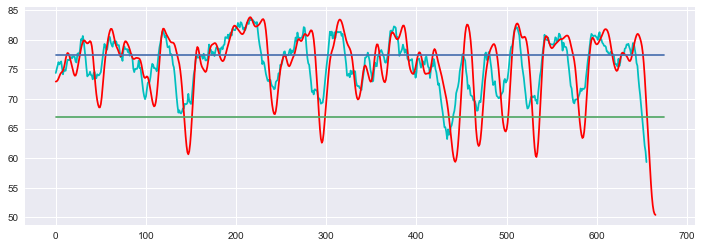

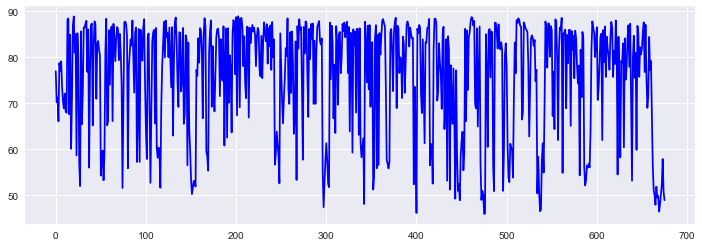

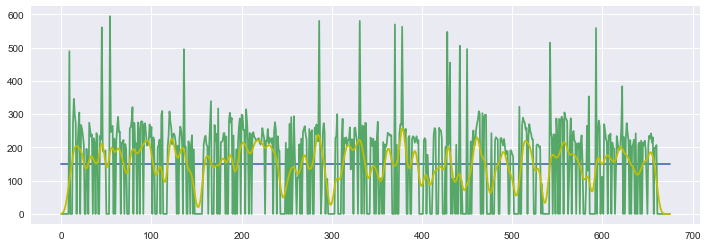

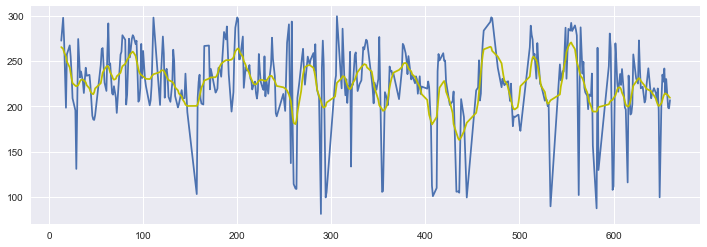

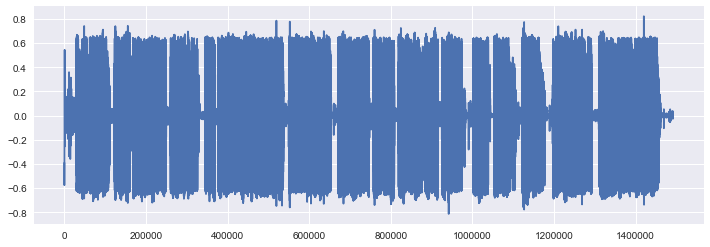

In [6]:
#print(intensity)

# Make a new figure
plt.figure(figsize=(12,4))

# show waveform
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def averageFilter(data,widthSegments):
    length = len(data)
    pitchAverageFilter = []
    for i in range(widthSegments,length-widthSegments):
        sumPitch = 0
        for k in range(i-widthSegments,i+widthSegments):
            sumPitch = sumPitch + data[k]
        sumPitch = sumPitch/(2*widthSegments)
        pitchAverageFilter.append(sumPitch)
    return pitchAverageFilter

order = 7
fs = 2250.0       # sample rate, Hz
cutoff = 50  # desired cutoff frequency of the filter, Hz

plt.plot(averageFilter(intensity.values[0],10) , 'c')
plt.plot(gaussian_filter(averageFilter(intensity.values[0],5), sigma=2) , 'r')
intensity_avg = sum(intensity.values[0])/len(intensity.values[0])
print("average intensity: " + str(intensity_avg))
p = np.poly1d([0,0,intensity_avg+2])
x = np.arange(len(intensity.values[0]))
z = p(x)
plt.plot(x,z)
p = np.poly1d([0,0,67]) #66
x = np.arange(len(intensity.values[0]))
z = p(x)
plt.plot(x,z)
#plt.plot(butter_lowpass_filter(intensity.values[0], cutoff, fs, order ), 'g')

plt.figure(figsize=(12,4))
plt.plot(intensity.values[0] , 'b')
# Make a new figure
plt.figure(figsize=(12,4))

# show waveform    
#plt.plot(averageFilter(pitch.selected_array['frequency'],5), 'r')
pitch_avg = sum(pitch.selected_array['frequency'])/len(pitch.selected_array['frequency'])
p = np.poly1d([0,0,pitch_avg+2])
x = np.arange(len(pitch.selected_array['frequency']))
z = p(x)
plt.plot(x,z)

pitchFilteredX = []
pitchFilteredY = []
for k in range(len(pitch.selected_array['frequency'])):
    if pitch.selected_array['frequency'][k] > 50 and pitch.selected_array['frequency'][k] < 300:
        pitchFilteredY.append(pitch.selected_array['frequency'][k])
        pitchFilteredX.append(k)


plt.plot(pitch.selected_array['frequency'])
plt.plot(gaussian_filter(pitch.selected_array['frequency'], sigma=3), 'y')
#plt.plot(butter_lowpass_filter(pitch.selected_array['frequency'], cutoff, fs, order ), 'g')
# Make a new figure
plt.figure(figsize=(12,4))

plt.plot(pitchFilteredX, pitchFilteredY)
plt.plot(pitchFilteredX, gaussian_filter(pitchFilteredY, sigma=3), 'y')

plt.figure(figsize=(12,4))

# show waveform
plt.plot(y)

#print("signal_avg is: ", signal_avg)
#print("signal_max is: ", signal_max)
#print("signal_min is: ", signal_min)
 
signal_avg_avg = sum(abs(signal_avg)/signal_avg.size)
signal_max_max = max(abs(signal_max))
signal_min_min = min(abs(signal_min))
signal_std_std = stat.stdev(signal_std)
 
#print("signal_avg_avg is: ", signal_avg_avg)
#print("signal_max_max is: ", signal_max_max)
#print("signal_min_min is: ", signal_min_min)
#print("signal_std_std is: ", signal_std_std)

In [7]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

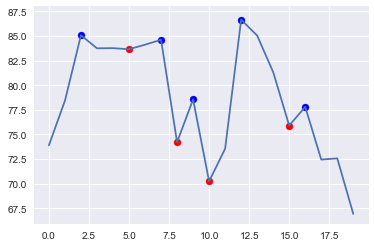

In [8]:
from matplotlib.pyplot import plot, scatter, show
series = [73.896799396377347, 78.427608070766098, 85.084245655100858, 83.758760593657883, 83.773326746681661, 83.663155305936115, 84.123438926442475, 84.625807027844786, 74.21107878786114, 78.559543022334026, 70.226226765809812, 73.549856642222991, 86.667299764816491, 85.052855079163535, 81.333352170080119, 75.903525027002004, 77.799965880928809, 72.444178740043299, 72.561820186828456, 66.915954390288164] #[0,0,0,2,0,0,0,-2,0,0,0,2,0,0,0,-2,0]
maxtab, mintab = peakdet(series,.3)
plot(series)
scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
show()

42.4194977427
86.8803329844
85.0920311198
58.40095238095238
Duration 58.40095238095238
Duration only speaking 58.40095238095239
Number of words 152
Speechrate 156.16183689111398
Speechrate only when speaking 156.16183689111395


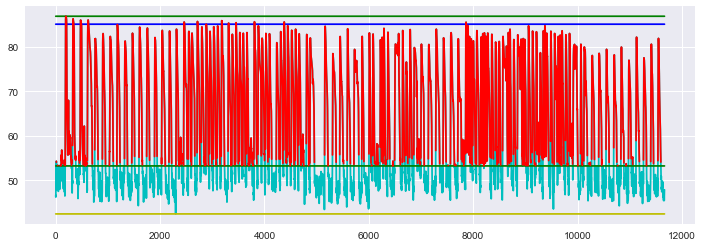

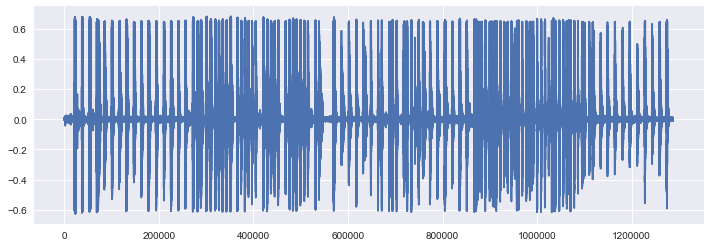

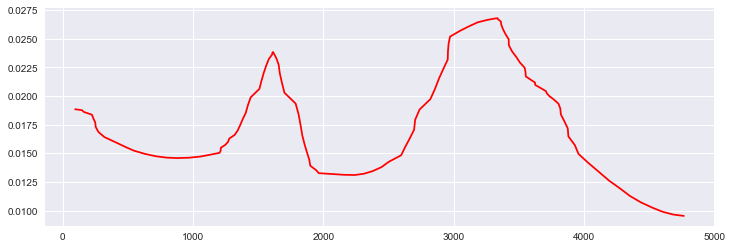

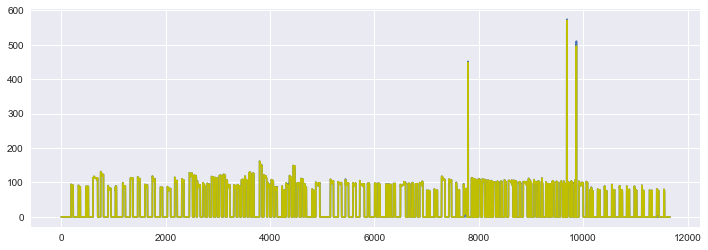

In [69]:
audio_path = './audio/nice.wav'

silencedb = 55
sample_time = 0.005
#mindip = 'minimum_dip_between_peaks'
#showtext = 'keep_Soundfiles_and_Textgrids'
#minpause = 'minimum_pause_duration'

#use intensity to get threshold
snd = parselmouth.Sound(audio_path)
intensity = snd.to_intensity(time_step=sample_time)
pitch = snd.to_pitch(time_step=sample_time)

# estimate noise floor
minint = np.amin(intensity.values[0])
# estimate noise max
maxint = np.amax(intensity.values[0])
#get .99 quantile to get maximum (without influence of non-speech sound bursts)
max99int = np.percentile(intensity.values[0], 99)

# estimate Intensity threshold
threshold = max99int + silencedb
threshold2 = maxint - max99int
threshold3 = silencedb - threshold2
if threshold < minint:
    threshold = minint

print(minint)
print(maxint)
print(max99int)

#plot stuff
plt.figure(figsize=(12,4))
plt.plot(intensity.values[0] , 'c')
p = np.poly1d([0,0,minint])
x = np.arange(len(intensity.values[0]))
z = p(x)
plt.plot(x,z,'y')
p = np.poly1d([0,0,maxint])
x = np.arange(len(intensity.values[0]))
z = p(x)
plt.plot(x,z,'g')
p = np.poly1d([0,0,max99int])
x = np.arange(len(intensity.values[0]))
z = p(x)
plt.plot(x,z,'b')
p = np.poly1d([0,0,threshold3])
x = np.arange(len(intensity.values[0]))
z = p(x)
plt.plot(x,z,'g')

duration = snd.duration
minpause = 0.1

speakingParts = []

data = gaussian_filter(intensity.values[0],sigma=0.1)

pitchFilteredX = []
pitchFilteredY = []
for k in range(len(pitch.selected_array['frequency'])):
    if pitch.selected_array['frequency'][k] > 50 and pitch.selected_array['frequency'][k] < 450:
        pitchFilteredY.append(pitch.selected_array['frequency'][k])
        pitchFilteredX.append(k)

#print(pitchFilteredX)
        
for i in range(0, len(data)):
    if data[i] > threshold3:# and i in pitchFilteredX:
        speakingParts.append((i,data[i]))
    else:
        speakingParts.append((i,np.nan))

#print(speakingParts)
x = [i[0] for i in speakingParts]
y = [i[1] for i in speakingParts]
plt.plot(x,y,'r')


from scipy import signal
'''
lastVoicePart = 0
splittedSpeakingParts = []
tmp = []
for i in range(0,len(speakingParts)):
    if speakingParts[i][0] > speakingParts[lastVoicePart][0] + 1:
        splittedSpeakingParts.append(tmp)
        tmp = []
    else:
        tmp.append(speakingParts[i][0])
    lastVoicePart = i

print(splittedSpeakingParts)
'''

lastVoicePart = 0
splittedSpeakingParts = []
tmp = []

#print(speakingParts)

for i in range(0,len(speakingParts) - 1):
    if np.isnan(speakingParts[i+1][1]):
        splittedSpeakingParts.append(tmp)
        tmp = []
    else:
        tmp.append(speakingParts[i+1][1]) #(speakingParts[i+1][0],

        
#print(splittedSpeakingParts)     

#print(splittedSpeakingParts)

# remove all parts with len < 1 of splittedSpeakingParts

pointX = []
pointY = []

numwords = 0
lastSpeak = 0
for i in range(len(splittedSpeakingParts)):
    maxtab, mintab = peakdet(splittedSpeakingParts[i],2)
    #print(splittedSpeakingParts[i])
    #print(maxtab)
    
    if splittedSpeakingParts[i] == []:
        lastSpeak = lastSpeak + 1
        #print(lastSpeak)
    if len(maxtab) > 0:
        numwords = numwords + len(maxtab)
        pointX.append(i)
        pointY.append(len(maxtab)/(lastSpeak + len(splittedSpeakingParts[i])))
        lastSpeak = 0
        #plt.figure(figsize=(12,4))
        #plt.plot(splittedSpeakingParts[i] , 'g')
        #plt.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='blue')
        #print(np.array(maxtab))

splittedSpeakingParts[:] = [item for item in splittedSpeakingParts if item != []]

plt.figure(figsize=(12,4))
y, sampling_rate = librosa.load(audio_path, dtype=np.float32)
plt.plot(y)

plt.figure(figsize=(12,4))
plt.plot(pointX,gaussian_filter(gaussian_filter(pointY, sigma=5),sigma=5), 'r')
#plt.plot(np.arange(len(pointX)-10),averageFilter(pointY, 5))
#plt.plot(pointX,pointY)
# shorten duration to start from first word and end with last word

duration_shorten = 0
for i in range(len(y)):
    if np.isnan(y[i]):
        duration_shorten = duration_shorten + 1

duration_onlySpeaking = ((duration/sample_time) - duration_shorten) * sample_time      
        
#print(duration_start)
#print(duration_end)
        
print(duration)
print("Duration",duration)
print("Duration only speaking",duration_onlySpeaking)
print("Number of words",numwords)
print("Speechrate",numwords/duration*60)
print("Speechrate only when speaking",numwords/duration_onlySpeaking*60)

speed = numwords/duration

# step 1: peaks erkennen
# step 2: peaks nur als valide annehmen, wenn der vorhergehende Intensity - dip größer als ein Minimalwert war
# step 3: Pitch Signal filtern mit Algorithmus von Paul Boersma
# step 4: peaks aus diesem Array wiederum nur als valide annehmen, wenn ein Hertz Wert im P.B. - Array vorhanden

plt.figure(figsize=(12,4))
plt.plot(pitch.selected_array['frequency'])
plt.plot(gaussian_filter(pitch.selected_array['frequency'], sigma=0.5), 'y')

#print(pitch.selected_array['frequency'])


[-0.85827281 -0.85092145 -0.8185546  -0.76693496 -0.816665   -0.73937541
 -0.84184156 -0.65234411 -0.84357683 -0.92963492  1.58464721  0.92237998
  0.0580235   0.76142607  1.74567402  1.88970539  0.44135533  1.04457262
  0.75991565  1.26684386  0.91065502  0.55905177  0.20890768  1.8611589
 -0.7137552   0.05611059 -0.03016519  0.16904195  0.99245325  0.0221931
 -0.10832301  0.72696763  0.27922799  0.84612065 -0.59610138 -0.3118682
  0.07955906 -0.57387221  0.30293291 -0.24361702 -0.38902929 -0.01745753
  0.20014815 -0.677181    0.79535567  0.12241261 -0.97177904  0.40466705
 -0.71922587 -0.04293598  0.25541349  0.22416597  0.17955804  0.68109227
  0.244062   -0.27045263 -0.23865011 -0.69465925 -0.54362838 -0.33868635
 -0.58895714 -0.97964149 -0.98385685 -0.98132705 -0.99334404 -0.0338602
 -0.45951894 -0.09827895 -0.78521449  1.31678483 -0.75860106  0.34000784
 -0.55200363 -0.08170996 -0.83102539 -0.30517454  1.04821389 -0.59092809
  0.32615005  0.49605336 -0.3263585  -0.63027461  0.079

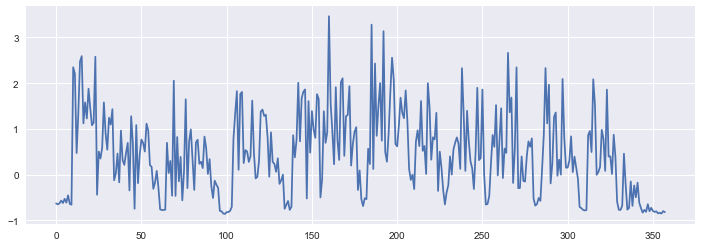

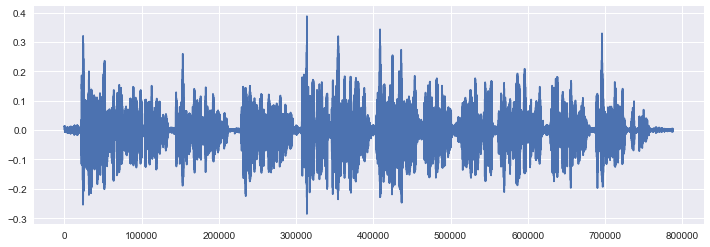

In [43]:
#feature scaling
features = np.zeros(len(signal_avg))
features2 = np.zeros(len(signal_avg))
a = signal_max - signal_min
for i in range(0, (len(signal_avg))):
    features[i] = (signal_avg[i] - signal_avg_avg)/signal_std_std
    features2[i] = (signal_std[i] - signal_std_std)/signal_avg_avg
#print (features)
#print (features2)

# Make a new figure
plt.figure(figsize=(12,4))

# show waveform
plt.plot(features2)

# Make a new figure
plt.figure(figsize=(12,4))

# show waveform
plt.plot(y)

In [87]:
features_filtered=features[features<0.1]
# features_filtered=features_filtered[features_filtered>0.1]
print(features_filtered)
print(features_filtered.size)

features_filtered2=features2[features2>0.1]
features_filtered2=features_filtered2[features_filtered2<0.25]
print(features_filtered2)
print(features_filtered2.size)

[-0.39570838 -0.45684292]
2
[]
0


# Mel spectrogram
This first step will show how to compute a [Mel](http://en.wikipedia.org/wiki/Mel_scale) spectrogram from an audio waveform.

In [ ]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.amplitude_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

# Make a new figure
plt.figure(figsize=(12,4))

# show waveform
plt.plot(y)

In [ ]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

sound_file = AudioSegment.from_wav(audio_path)
audio_chunks = split_on_silence(sound_file, 
    # must be silent for at least half a second
    min_silence_len=50,

    # consider it silent if quieter than -16 dBFS
    silence_thresh=-16
)

for i, chunk in enumerate(audio_chunks):

    out_file = ".//splitAudio//chunk{0}.wav".format(i)
    print "exporting", out_file
    chunk.export(out_file, format="wav")

# Harmonic-percussive source separation

Before doing any signal analysis, let's pull apart the harmonic and percussive components of the audio.  This is pretty easy to do with the `effects` module.

In [5]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

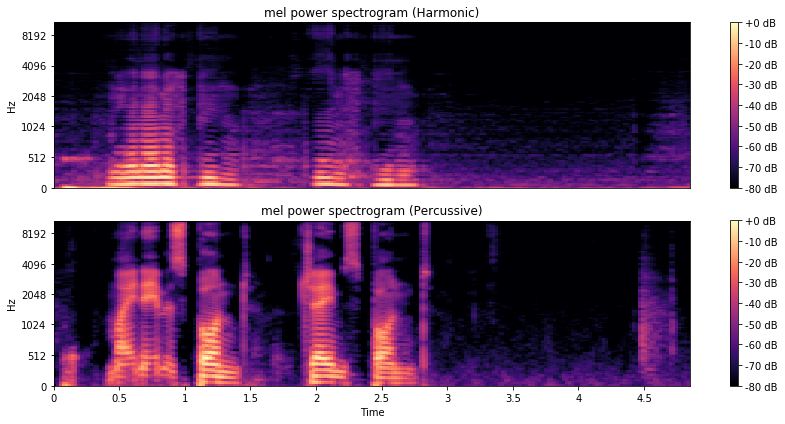

In [6]:
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

# Chromagram

Next, we'll extract [Chroma](http://en.wikipedia.org/wiki/Pitch_class) features to represent pitch class information.

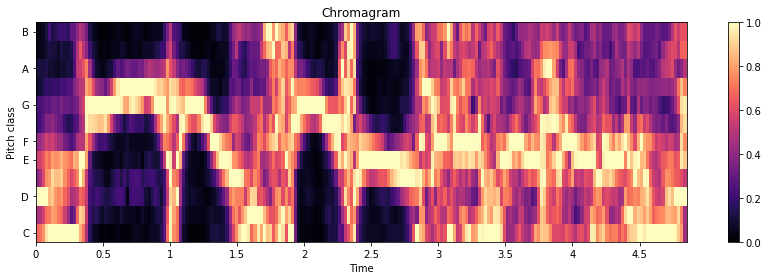

In [7]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

# MFCC

[Mel-frequency cepstral coefficients](http://en.wikipedia.org/wiki/Mel-frequency_cepstrum) are commonly used to represent texture or timbre of sound.

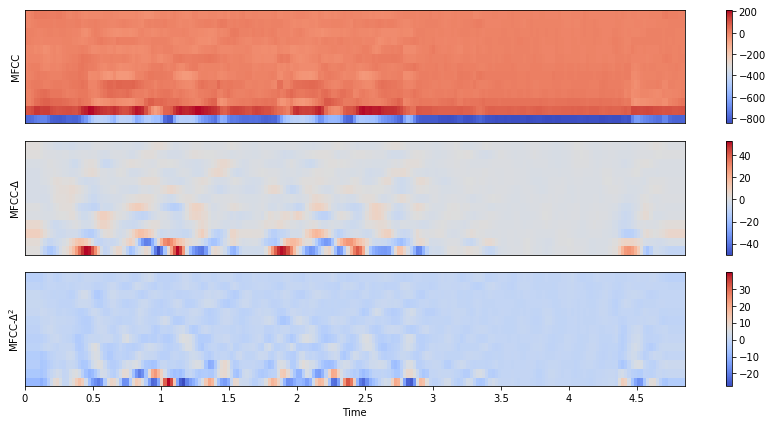

In [8]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

# Beat tracking

The beat tracker returns an estimate of the tempo (in beats per minute) and frame indices of beat events.

The input can be either an audio time series (as we do below), or an onset strength envelope as calculated by `librosa.onset.onset_strength()`.

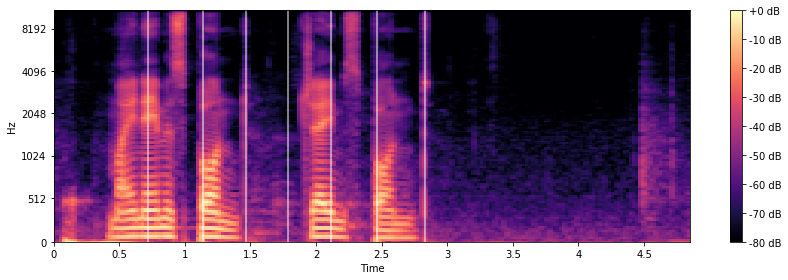

In [9]:
# Now, let's run the beat tracker.
# We'll use the percussive component for this part
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

By default, the beat tracker will trim away any leading or trailing beats that don't appear strong enough.  

To disable this behavior, call `beat_track()` with `trim=False`.

In [10]:
print('Estimated tempo:        %.2f BPM' % tempo)

print('First 5 beat frames:   ', beats[:5])

# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

# We could also get frame numbers from times by librosa.time_to_frames()

Estimated tempo:        161.50 BPM
First 5 beat frames:    [31 49 63 77 91]
First 5 beat times:     [ 0.71981859  1.13777778  1.46285714  1.78793651  2.11301587]


# Beat-synchronous feature aggregation

Once we've located the beat events, we can use them to summarize the feature content of each beat.

This can be useful for reducing data dimensionality, and removing transient noise from the features.

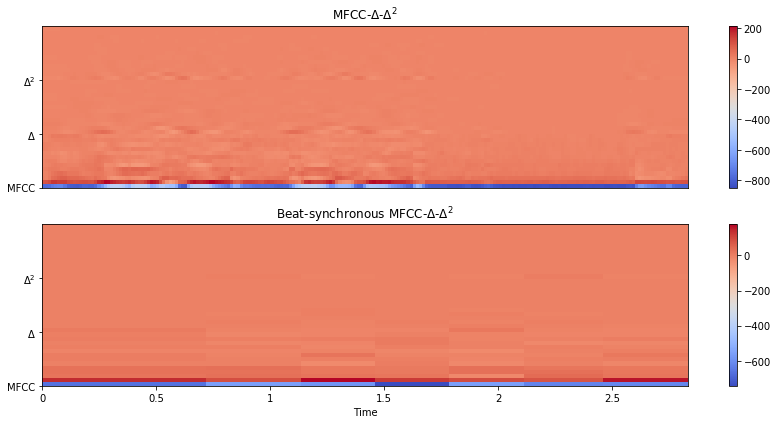

In [11]:
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

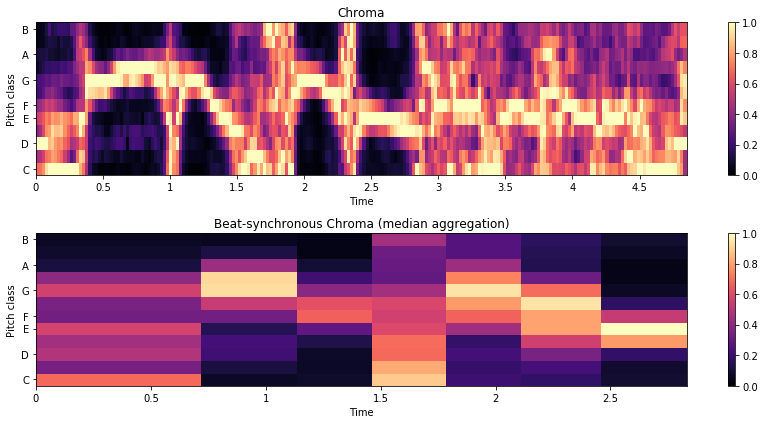

In [12]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.median)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (median aggregation)')

plt.colorbar()
plt.tight_layout()